To use Kalman filter to implement the pair trading strategy of S&P 500 ETF and the Dow Jones Industrial ETF.

(a). Derive the beta update equation (Kalman filter) for the pair trading strategy of the two ETFs ( which is the same format with the last equation on page 72).

(b). Code up the pair trading strategy and compare rolling regression vs Kalman filtering.


In [59]:
# standard magic
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

# disable warnings
import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import numpy as np
np.random.seed(44)
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os


# 1. Data Processing
1. load data, drop nan rows
2. df_djia and df_spy containing the closing and volume

In [61]:
# func for loading data, pase time as index, drop nan rows
def loadData(ticker, root='C:/Users/Allen Tao/Desktop/FRE 7773/Assignments/A3/A3 Data/'):
    """
    Automate data loading process: loading, parse time as index, drop nan rows
    Input: ticker(str), root(default to data storage folder)
    output: df for each ticker
    """
    # load
    df = pd.read_csv(root + f'{ticker}.csv', index_col='Date', parse_dates=True)
    # drop nan rows
    df.dropna(axis=0, inplace=True)
    
    return df


In [62]:
# load data
df_djia = loadData('djia').rename(columns={'PX_LAST': 'djia', 'PX_VOLUME': 'djia_volume'})
df_spy = loadData('spy').rename(columns={'PX_LAST': 'spy', 'PX_VOLUME': 'spy_volume'})

df_djia.describe()
df_spy.describe()
df_spy.head()

,djia,djia_volume
count,5536.000000,5.536000e+03
mean,155.389434,7.404603e+06
std,69.649834,6.944374e+06
min,65.440000,1.349000e+05
25%,105.000000,3.475380e+06
50%,125.585000,5.590155e+06
75%,181.192500,8.708932e+06
max,364.840000,9.169958e+07


,spy,spy_volume
count,5536.000000,5.536000e+03
mean,177.324876,1.100707e+08
std,85.478755,9.577426e+07
min,68.110000,1.436600e+06
25%,117.515000,4.920124e+07
50%,141.062500,8.082009e+07
75%,212.542500,1.451701e+08
max,477.480000,8.715469e+08


,spy,spy_volume
Date,,
2000-01-03,145.4375,8164300
2000-01-04,139.7500,8089800
2000-01-05,140.0000,12177900
2000-01-06,137.7500,6227200
2000-01-07,145.7500,8066500


# 2. Rolling Linear Regression Residual and Sigma^2
1. formula for rolling ols: spy = beta * djia + v
2. rolling period: 6mo * 20 trading days/mo = 120days/window
3. rollingOLS reference: https://lost-stats.github.io/Time_Series/Rolling_Regression.html

In [63]:
# form df containing tgt and features
df = pd.concat([df_spy['spy'], df_djia['djia']], axis=1)
df.head()

,spy,djia
Date,,
2000-01-03,145.4375,113.5000
2000-01-04,139.7500,109.7656
2000-01-05,140.0000,111.1875
2000-01-06,137.7500,111.7500
2000-01-07,145.7500,115.5000


In [64]:
# rolling reg model
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# supress y-intercept using -1
roll_reg = RollingOLS.from_formula('spy ~ djia -1', window=120, data=df)
roll_model = roll_reg.fit()


<AxesSubplot:xlabel='Date'>

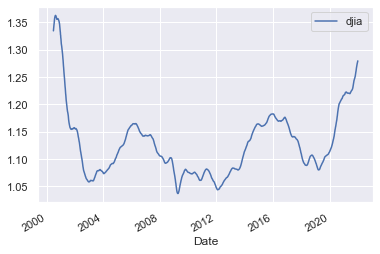

In [65]:
# plot beta vs. time
roll_model.params.plot()


In [66]:
# compute residuals, put into df, remove nan rows
roll_res = pd.DataFrame(df['spy'] - roll_model.params['djia'] * df['djia'], columns=['res'])

# roll_model.params
roll_res.dropna(axis=0, inplace=True)
roll_res


,res
Date,
2000-06-22,6.828869
2000-06-23,4.903965
2000-06-26,4.622642
2000-06-27,4.230472
2000-06-28,4.499636
...,...
2021-12-27,13.574960
2021-12-28,11.636351
2021-12-29,10.973122


<AxesSubplot:xlabel='Date'>

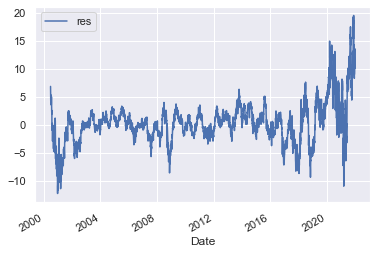

In [67]:
# plot residual
roll_res.plot()

In [68]:
# find residual var_t
def vart(res):
    """
    take res df, add var_t col
    input: df res
    output: df res with additional col named var
    """
    res['var'] = np.nan
    for i in range(len(res)):
        res.iloc[i,1] = np.var(res.iloc[0:i, 0], ddof=1)
    return res


In [69]:
vart(roll_res)

,res,var
Date,,
2000-06-22,6.828869,NaN
2000-06-23,4.903965,NaN
2000-06-26,4.622642,1.852628
2000-06-27,4.230472,1.441973
2000-06-28,4.499636,1.334241
...,...,...
2021-12-27,13.574960,12.911929
2021-12-28,11.636351,12.942192
2021-12-29,10.973122,12.963608


# 3. Kalman Filter Set up
to simplify reference to parts of the equation, we denote the beta-hat_t|t formula as follows:

b_t = b_t-1 + k_gain * r_t

where b_t is the current beta, b_t-1 is the previous beta, r_t is current residual using current prices and b_t-1, k_gain is current djia / (current djia^2 * gamma^-1), where gamma = state variance / measurement error

 

In [70]:
# run first 120 day model (matching window), to establish baseline for kf model (b_0)
# compute base case
import statsmodels.api as sm
from statsmodels.formula.api import ols

# get first 120 lines
base_df = df.iloc[:120]
base_reg = ols('spy ~ djia -1', data=base_df)
base_model = base_reg.fit()
base_model.params

djia    1.334578
dtype: float64

In [71]:
# keep original df intact
kf = df.copy(deep=True)

In [72]:
# create new columns to contain needed variables
kf['Qt'] = np.nan
kf['Rt'] = np.nan
kf['wt'] = np.nan
kf['vt'] = np.nan
kf['b_tt-1'] = np.nan
kf['r_t'] = np.nan
kf['sv'] = np.nan
kf['me'] = np.nan
kf['gamma'] = np.nan
kf['b_tt'] = np.nan
kf

,spy,djia,Qt,Rt,wt,vt,b_tt-1,r_t,sv,me,gamma,b_tt
Date,,,,,,,,,,,,
2000-01-03,145.4375,113.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,139.7500,109.7656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,140.0000,111.1875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,137.7500,111.7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,145.7500,115.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,477.2600,362.9200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-28,476.8700,363.9900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-29,477.4800,364.8400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Qt = sigw: var of b_t, updated by row; initialized by random.rand

Rt = sigv: var of spy, updated by row; initialized by rand generation according to 120 day ols var

wt (dist with var = Qt = sigw): generated from Qt

vt (dist with var = Rt = sigv): generated from Rt

b_tt-1: b_t-1 + wt; b_t-1 initialized by 120 row ols (b_0)

r_t = spy - djia * b_tt-1

sv = P_tt-1: var of all b_tt-1 of prev rows; initialized with a rand sample from N(0, Qt)

me = Rt = sigv: var of spy of prev rows, updated by row

gamma = sv / me

b_tt = b_tt-1 + djia * r_t / (djia^2 + gamma^-1)

In [73]:
# fill in from 121st row
# Qt random initialize
kf.iloc[120, 2] = np.random.rand()
# Rt initialize from var of spy for 1st 120r
kf.iloc[120, 3] = np.var(kf.iloc[:120, 1], ddof=1)
# generate wt
kf.iloc[120, 4] = np.random.normal(0, kf.iloc[120, 2])
# generate vt
kf.iloc[120, 5] = np.random.normal(0, kf.iloc[120, 3])
# compute b_tt-1
kf.iloc[120, 6] = base_model.params[0] + kf.iloc[120, 4]
# compute r_t
kf.iloc[120, 7] = kf.iloc[120, 0] - kf.iloc[120, 1] * kf.iloc[120, 6]
# initialize sv
kf.iloc[120, 8] = np.random.normal(0, kf.iloc[120, 2])
# insert me = Rt
kf.iloc[120, 9] = kf.iloc[120, 3]
# compute gamma
kf.iloc[120, 10] = kf.iloc[120, 8] / kf.iloc[120, 9]
# compute b_tt
kf.iloc[120, 11] = kf.iloc[120, 6] + kf.iloc[120, 1] * kf.iloc[120, 7] / (kf.iloc[120, 1] ** 2 + kf.iloc[120, 10] ** (-1))


In [74]:
kf.iloc[120:124]

,spy,djia,Qt,Rt,wt,vt,b_tt-1,r_t,sv,me,gamma,b_tt
Date,,,,,,,,,,,,
2000-06-23,144.3750,104.4375,0.834842,17.369466,0.237461,-7.981175,1.572039,-19.804818,-1.140758,17.369466,-0.065676,1.382141
2000-06-26,146.2344,105.9688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-27,145.1563,105.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-28,145.5625,105.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# fill b_0 into kf[119, b_tt]
kf.iloc[119, 11] = base_model.params[0]
kf.iloc[119, 6] = base_model.params[0]
kf.iloc[119]

spy       145.625000
djia      104.000000
Qt               NaN
Rt               NaN
wt               NaN
vt               NaN
b_tt-1      1.334578
r_t              NaN
sv               NaN
me               NaN
gamma            NaN
b_tt        1.334578
Name: 2000-06-22 00:00:00, dtype: float64

In [76]:
# fill in val of all following rows:
for i in range(121, len(kf)):
    # compute Qt 
    kf.iloc[i, 2] = np.var(kf.iloc[119:i, 11], ddof=1)
    # compute Rt
    kf.iloc[i, 3] = np.var(kf.iloc[119:i, 0], ddof=1)
    # generate wt
    kf.iloc[i, 4] = np.random.normal(0, kf.iloc[i, 2])
    # generate vt
    kf.iloc[i, 5] = np.random.normal(0, kf.iloc[i, 3])
    # compute b_tt-1
    kf.iloc[i, 6] = kf.iloc[i - 1, 11] + kf.iloc[i, 4]
    # compute r_t
    kf.iloc[i, 7] = kf.iloc[i, 0] - kf.iloc[i, 1] * kf.iloc[i, 6]
    # compute sv
    kf.iloc[i, 8] = np.var(kf.iloc[119:i, 6], ddof=1)
    # insert me = Rt
    kf.iloc[i, 9] = kf.iloc[i, 3]
    # compute gamma
    kf.iloc[i, 10] = kf.iloc[i, 8] / kf.iloc[i, 9]
    # compute b_tt
    kf.iloc[i, 11] = kf.iloc[i, 6] + kf.iloc[i, 1] * kf.iloc[i, 7] / (kf.iloc[i, 1] ** 2 + kf.iloc[i, 10] ** (-1))


In [77]:
kf[119:136]

,spy,djia,Qt,Rt,wt,vt,b_tt-1,r_t,sv,me,gamma,b_tt
Date,,,,,,,,,,,,
2000-06-22,145.6250,104.0000,NaN,NaN,NaN,NaN,1.334578,NaN,NaN,NaN,NaN,1.334578
2000-06-23,144.3750,104.4375,0.834842,17.369466,0.237461,-7.981175,1.572039,-19.804818,-1.140758,17.369466,-0.065676,1.382141
2000-06-26,146.2344,105.9688,0.001131,0.781250,-0.001532,-1.187413,1.380608,-0.066990,0.028194,0.781250,0.036088,1.379978
2000-06-27,145.1563,105.3750,0.000721,0.898539,0.001127,0.253574,1.381105,-0.377643,0.015859,0.898539,0.017649,1.377539
2000-06-28,145.5625,105.3750,0.000517,0.615304,-0.001339,-1.407946,1.376200,0.545381,0.011148,0.615304,0.018117,1.381350
2000-06-29,144.1875,104.2500,0.000420,0.470708,-0.000577,-0.116266,1.380774,0.241827,0.008695,0.470708,0.018472,1.383082
2000-06-30,145.2813,104.3750,0.000360,0.617824,-0.000122,0.198370,1.382960,0.934833,0.007088,0.617824,0.011472,1.391846
2000-07-03,147.2813,105.9688,0.000350,0.516041,0.000293,0.300328,1.392139,-0.241977,0.005971,0.516041,0.011571,1.389873
2000-07-05,144.6250,105.0000,0.000325,0.982163,-0.000396,-0.126266,1.389477,-1.270107,0.005128,0.982163,0.005222,1.377587


In [78]:
kf.tail()

,spy,djia,Qt,Rt,wt,vt,b_tt-1,r_t,sv,me,gamma,b_tt
Date,,,,,,,,,,,,
2021-12-27,477.26,362.92,0.003839,7365.410277,-0.000780,-4534.885451,1.313496,0.565960,0.003900,7365.410277,5.295361e-07,1.313598
2021-12-28,476.87,363.99,0.003845,7380.616911,0.003664,5553.109307,1.317262,-2.600290,0.003906,7380.616911,5.292306e-07,1.316794
2021-12-29,477.48,364.84,0.003851,7395.768698,0.001631,504.486959,1.318425,-3.534279,0.003912,7395.768698,5.289654e-07,1.317788
2021-12-30,476.16,364.07,0.003857,7410.976215,-0.002071,7806.816664,1.315717,-2.853211,0.003918,7410.976215,5.287079e-07,1.315204
2021-12-31,474.96,363.32,0.003863,7426.026318,-0.003702,-8656.015001,1.311502,-1.535088,0.003924,7426.026318,5.284361e-07,1.311227


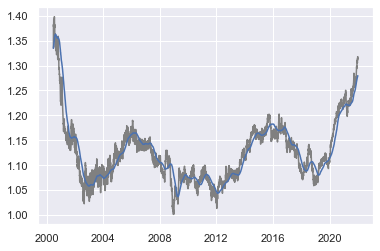

In [79]:
# plot b_tt
plt.plot(kf['b_tt'], c='grey')
plt.plot(roll_model.params, c='b')

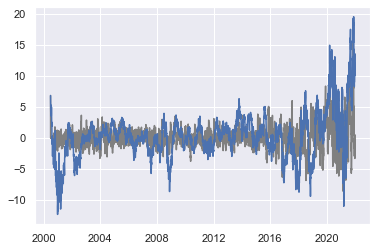

In [80]:
# compute residuals
kf_res = pd.DataFrame(kf['spy'] - kf['djia'] * kf['b_tt'], columns=['res'])

# plot residuals
plt.plot(kf_res, c='grey')
plt.plot(roll_res.iloc[:,0], c='b')

In [81]:
vart(kf_res)

,res,var
Date,,
2000-01-03,NaN,NaN
2000-01-04,NaN,NaN
2000-01-05,NaN,NaN
2000-01-06,NaN,NaN
2000-01-07,NaN,NaN
...,...,...
2021-12-27,0.529061,3.253779
2021-12-28,-2.429912,3.253206
2021-12-29,-3.301801,3.253822


# 4. Generate Buy/Sell Signals
1. func to generate b/s singals, using different k
2. generate b/s using kf and rolling beta

In [82]:
# function that generates b/s signal, based on residual and var. 
# k's same as  paper are tested.
def signalBS(residual, k=[0.5, 1, 2]):
    """
    generate new columns in residual df containing buy/sell signals for each day by evaluating buy if res > k*var;
    +1 for buy and -1 for sell
    input: residual: df containing residual of each day and variance of all residual up to time t; k: array of constant k as 
    parameter
    output: updated df residual with new columns generated containing b/s decisions
    """
    for n in k:
        residual[f'{n}_var'] = residual['var'] * n
        residual[f'{n}_spy'] = np.nan
        residual[f'{n}_djia'] = np.nan
        for i in range(len(residual)):
            if residual['res'][i] >= residual[f'{n}_var'][i]:
                residual[f'{n}_spy'][i] = 1
                residual[f'{n}_djia'][i] = -1
            elif residual['res'][i] <= - residual[f'{n}_var'][i]:
                residual[f'{n}_spy'][i] = -1
                residual[f'{n}_djia'][i] = 1
            else: 
                residual[f'{n}_spy'][i] = 0
                residual[f'{n}_djia'][i] = 0
                
    return residual.copy(deep=True)
    

In [83]:
# generate rolling ols bs signals, cut off first 2 rows as kf used it as initiation 
roll_bs = signalBS(roll_res)
roll_bs = roll_bs.iloc[2:,:]
roll_bs


,res,var,0.5_var,0.5_spy,0.5_djia,1_var,1_spy,1_djia,2_var,2_spy,2_djia
Date,,,,,,,,,,,
2000-06-26,4.622642,1.852628,0.926314,1.0,-1.0,1.852628,1.0,-1.0,3.705256,1.0,-1.0
2000-06-27,4.230472,1.441973,0.720986,1.0,-1.0,1.441973,1.0,-1.0,2.883946,1.0,-1.0
2000-06-28,4.499636,1.334241,0.667120,1.0,-1.0,1.334241,1.0,-1.0,2.668482,1.0,-1.0
2000-06-29,4.516708,1.084364,0.542182,1.0,-1.0,1.084364,1.0,-1.0,2.168728,1.0,-1.0
2000-06-30,5.319334,0.909226,0.454613,1.0,-1.0,0.909226,1.0,-1.0,1.818452,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,13.574960,12.911929,6.455964,1.0,-1.0,12.911929,1.0,-1.0,25.823857,0.0,0.0
2021-12-28,11.636351,12.942192,6.471096,1.0,-1.0,12.942192,0.0,0.0,25.884385,0.0,0.0
2021-12-29,10.973122,12.963608,6.481804,1.0,-1.0,12.963608,0.0,0.0,25.927216,0.0,0.0


In [85]:
roll_bs.describe()

,res,var,0.5_var,0.5_spy,0.5_djia,1_var,1_spy,1_djia,2_var,2_spy,2_djia
count,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000
mean,0.289063,8.295777,4.147888,0.037673,-0.037673,8.295777,0.015512,-0.015512,16.591553,0.004063,-0.004063
std,3.606534,2.991678,1.495839,0.451226,0.451226,2.991678,0.205528,0.205528,5.983355,0.063616,0.063616
min,-12.312031,0.596450,0.298225,-1.000000,-1.000000,0.596450,-1.000000,-1.000000,1.192901,0.000000,-1.000000
25%,-1.414802,6.150681,3.075340,0.000000,0.000000,6.150681,0.000000,0.000000,12.301362,0.000000,0.000000
50%,0.163904,7.169774,3.584887,0.000000,0.000000,7.169774,0.000000,0.000000,14.339547,0.000000,0.000000
75%,1.801131,9.748024,4.874012,0.000000,0.000000,9.748024,0.000000,0.000000,19.496049,0.000000,0.000000
max,19.516543,21.215772,10.607886,1.000000,1.000000,21.215772,1.000000,1.000000,42.431544,1.000000,0.000000


In [86]:
# kf bs
kf_bs = signalBS(kf_res)
kf_bs.iloc[121:].describe()

,res,var,0.5_var,0.5_spy,0.5_djia,1_var,1_spy,1_djia,2_var,2_spy,2_djia
count,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000,5415.000000
mean,0.134087,1.217355,0.608677,0.034349,-0.034349,1.217355,0.030286,-0.030286,2.434709,0.012373,-0.012373
std,1.802507,0.635766,0.317883,0.809713,0.809713,0.635766,0.616698,0.616698,1.271532,0.326225,0.326225
min,-9.295470,0.596677,0.298339,-1.000000,-1.000000,0.596677,-1.000000,-1.000000,1.193354,-1.000000,-1.000000
25%,-0.750374,1.001301,0.500651,-1.000000,-1.000000,1.001301,0.000000,0.000000,2.002602,0.000000,0.000000
50%,0.047946,1.041370,0.520685,0.000000,0.000000,1.041370,0.000000,0.000000,2.082739,0.000000,0.000000
75%,0.889986,1.213838,0.606919,1.000000,1.000000,1.213838,0.000000,0.000000,2.427676,0.000000,0.000000
max,15.292963,23.128045,11.564022,1.000000,1.000000,23.128045,1.000000,1.000000,46.256090,1.000000,1.000000


# 5. Backtest Returns
1. find historical returns
2. adjust all df (return, kf b/s, rolling b/s) of various k's to same # of rows
3. split each b/s into 3 df contianing data of single k's, contain them in matrix. (2-3 are weird, i do this just bc idk how to better organize the data structure early on. if it works, it works yea?)
4. compute back test return results
5. plot backtest results

In [88]:
# find daily returns from df
df['spy_ret'] = df['spy'].pct_change(1)
df['djia_ret'] = df['djia'].pct_change(1)
df

,spy,djia,spy_ret,djia_ret
Date,,,,
2000-01-03,145.4375,113.5000,NaN,NaN
2000-01-04,139.7500,109.7656,-0.039106,-0.032902
2000-01-05,140.0000,111.1875,0.001789,0.012954
2000-01-06,137.7500,111.7500,-0.016071,0.005059
2000-01-07,145.7500,115.5000,0.058076,0.033557
...,...,...,...,...
2021-12-27,477.2600,362.9200,0.014152,0.009907
2021-12-28,476.8700,363.9900,-0.000817,0.002948
2021-12-29,477.4800,364.8400,0.001279,0.002335


In [89]:
# cut index df, KF bs df, rolling bs df, to the same size by matching indices
df = df[df.index.isin(roll_bs.index)]
kf_bs = kf_bs[kf_bs.index.isin(roll_bs.index)]


In [90]:
# reorganize b/s signals into arrays containing dfs for easier manipulation
def splitBS(bs):
    """
    split current b/s signal df into an array containing 3 dfs, each containing b/s for a single k
    input: bs: 1 big df containing random stuff and b/s signals
    output: res: array with 3 dfs each with b/s signal for a single k
    """
    k05 = bs[['0.5_spy', '0.5_djia']].rename(columns={'0.5_spy': 'spy', '0.5_djia': 'djia'})
    k1 = bs[['1_spy', '1_djia']].rename(columns={'1_spy': 'spy', '1_djia': 'djia'})
    k2 = bs[['2_spy', '2_djia']].rename(columns={'2_spy': 'spy', '2_djia': 'djia'})
    res = [k05, k1, k2]
    return res


In [91]:
# split the bs dataframes
rolls = splitBS(roll_bs)
kfs = splitBS(kf_bs)
kfs

[            spy  djia
 Date                 
 2000-06-26  0.0   0.0
 2000-06-27  0.0   0.0
 2000-06-28  0.0   0.0
 2000-06-29  0.0   0.0
 2000-06-30  0.0   0.0
 ...         ...   ...
 2021-12-27  0.0   0.0
 2021-12-28 -1.0   1.0
 2021-12-29 -1.0   1.0
 2021-12-30 -1.0   1.0
 2021-12-31  0.0   0.0
 
 [5415 rows x 2 columns],
             spy  djia
 Date                 
 2000-06-26  0.0   0.0
 2000-06-27  0.0   0.0
 2000-06-28  0.0   0.0
 2000-06-29  0.0   0.0
 2000-06-30  0.0   0.0
 ...         ...   ...
 2021-12-27  0.0   0.0
 2021-12-28  0.0   0.0
 2021-12-29 -1.0   1.0
 2021-12-30  0.0   0.0
 2021-12-31  0.0   0.0
 
 [5415 rows x 2 columns],
             spy  djia
 Date                 
 2000-06-26  0.0   0.0
 2000-06-27  0.0   0.0
 2000-06-28  0.0   0.0
 2000-06-29  0.0   0.0
 2000-06-30  0.0   0.0
 ...         ...   ...
 2021-12-27  0.0   0.0
 2021-12-28  0.0   0.0
 2021-12-29  0.0   0.0
 2021-12-30  0.0   0.0
 2021-12-31  0.0   0.0
 
 [5415 rows x 2 columns]]

In [92]:
# function for backtest returns
def backtest(arr, ret, k=[0.5, 1, 2]):
    """
    applying b/s on daily ret, find daily total ret, then cumprod to find cumret
    input: arr: array containing 3 df, each containing b/s resulting from a k; ret: 1df containing daily ret
    ouput: res: 1 df containing cumret
    """
    res = pd.DataFrame()
    # multiply daily ret inplace of b/s, find sum of two ret for daily ret, then cumprod
    for i, d in enumerate(arr):
        d['spy_ret'] = d['spy'] * ret['spy_ret']
        d['djia_ret'] = d['djia'] * ret['djia_ret']
        d['dret'] = d['spy_ret'] + d['djia_ret']
        d['cumpl'] = np.cumprod(1 + d['dret'].values)
        n = k[i]
        res[f'{n}'] = d['cumpl']
    return res


In [93]:
roll_backtest = backtest(rolls, df)
kf_backtest = backtest(kfs, df)

<AxesSubplot:xlabel='Date'>

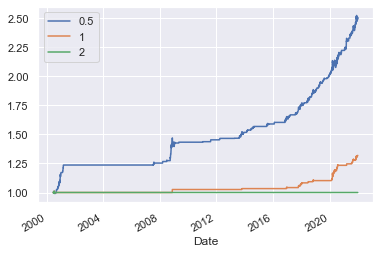

In [94]:
roll_backtest.plot()

Pretty good, 250% return over 20 years

<AxesSubplot:xlabel='Date'>

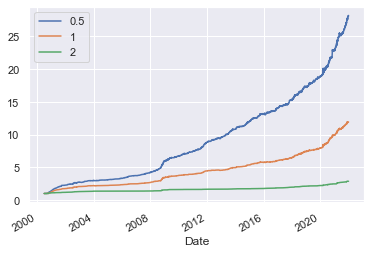

In [95]:
kf_backtest.plot()

kf printed a fk ton of money geez. Ima yolo my life savings tomorrow

In [96]:
print('Done!')

Done!
